In [1]:
import os

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read datasets to memory in ascending order
DATA_FOLDER = './data'

dataframes = [
    pd.read_csv(f'{DATA_FOLDER}/{filename}', names=['time', 'x', 'y', 'z', 'label'])
    for filename in sorted(os.listdir(DATA_FOLDER), key=lambda f: int(f.split('.')[0]))
]

for index, dataframe in enumerate(dataframes):
    # Add person id to each dataset
    dataframe['person'] = index + 1
    print(f'Person #{index+1} has {len(dataframe)} records')
    

dfs = pd.concat(dataframes)

Person #1 has 162501 records
Person #2 has 138001 records
Person #3 has 102341 records
Person #4 has 122201 records
Person #5 has 160001 records
Person #6 has 140901 records
Person #7 has 163001 records
Person #8 has 138001 records
Person #9 has 166741 records
Person #10 has 126801 records
Person #11 has 104451 records
Person #12 has 114702 records
Person #13 has 67651 records
Person #14 has 116101 records
Person #15 has 103501 records


#### Take a look at random person dataset

In [3]:
df = dfs[dfs.person==2]
df.describe().T

count          mean           std     min      25%      50%  \
time    138001.0  69000.000000  39837.601661     0.0  34500.0  69000.0   
x       138001.0   2082.035877     89.664941  1094.0   1982.0   2119.0   
y       138001.0   2326.237948     73.010098     2.0   2286.0   2339.0   
z       138001.0   1917.805770    109.799316     2.0   1836.0   1962.0   
label   138001.0      3.669698      2.342484     0.0      1.0      3.0   
person  138001.0      2.000000      0.000000     2.0      2.0      2.0   

             75%       max  
time    103500.0  138000.0  
x         2148.0    3625.0  
y         2352.0    4094.0  
z         1987.0    4094.0  
label        6.0       7.0  
person       2.0       2.0

Labels are codified by numbers
1. Working at Computer
2. Standing Up, Walking and Going up\down stairs
3. Standing
4. Walking
5. Going Up\Down Stairs
6. Walking and Talking with Someone
7. Talking while Standing

Also keep in mind that small fraction of records is not labeled

In [4]:
dfs[dfs.label == 0].size

22314

#### Visualise activities acceleration for that person

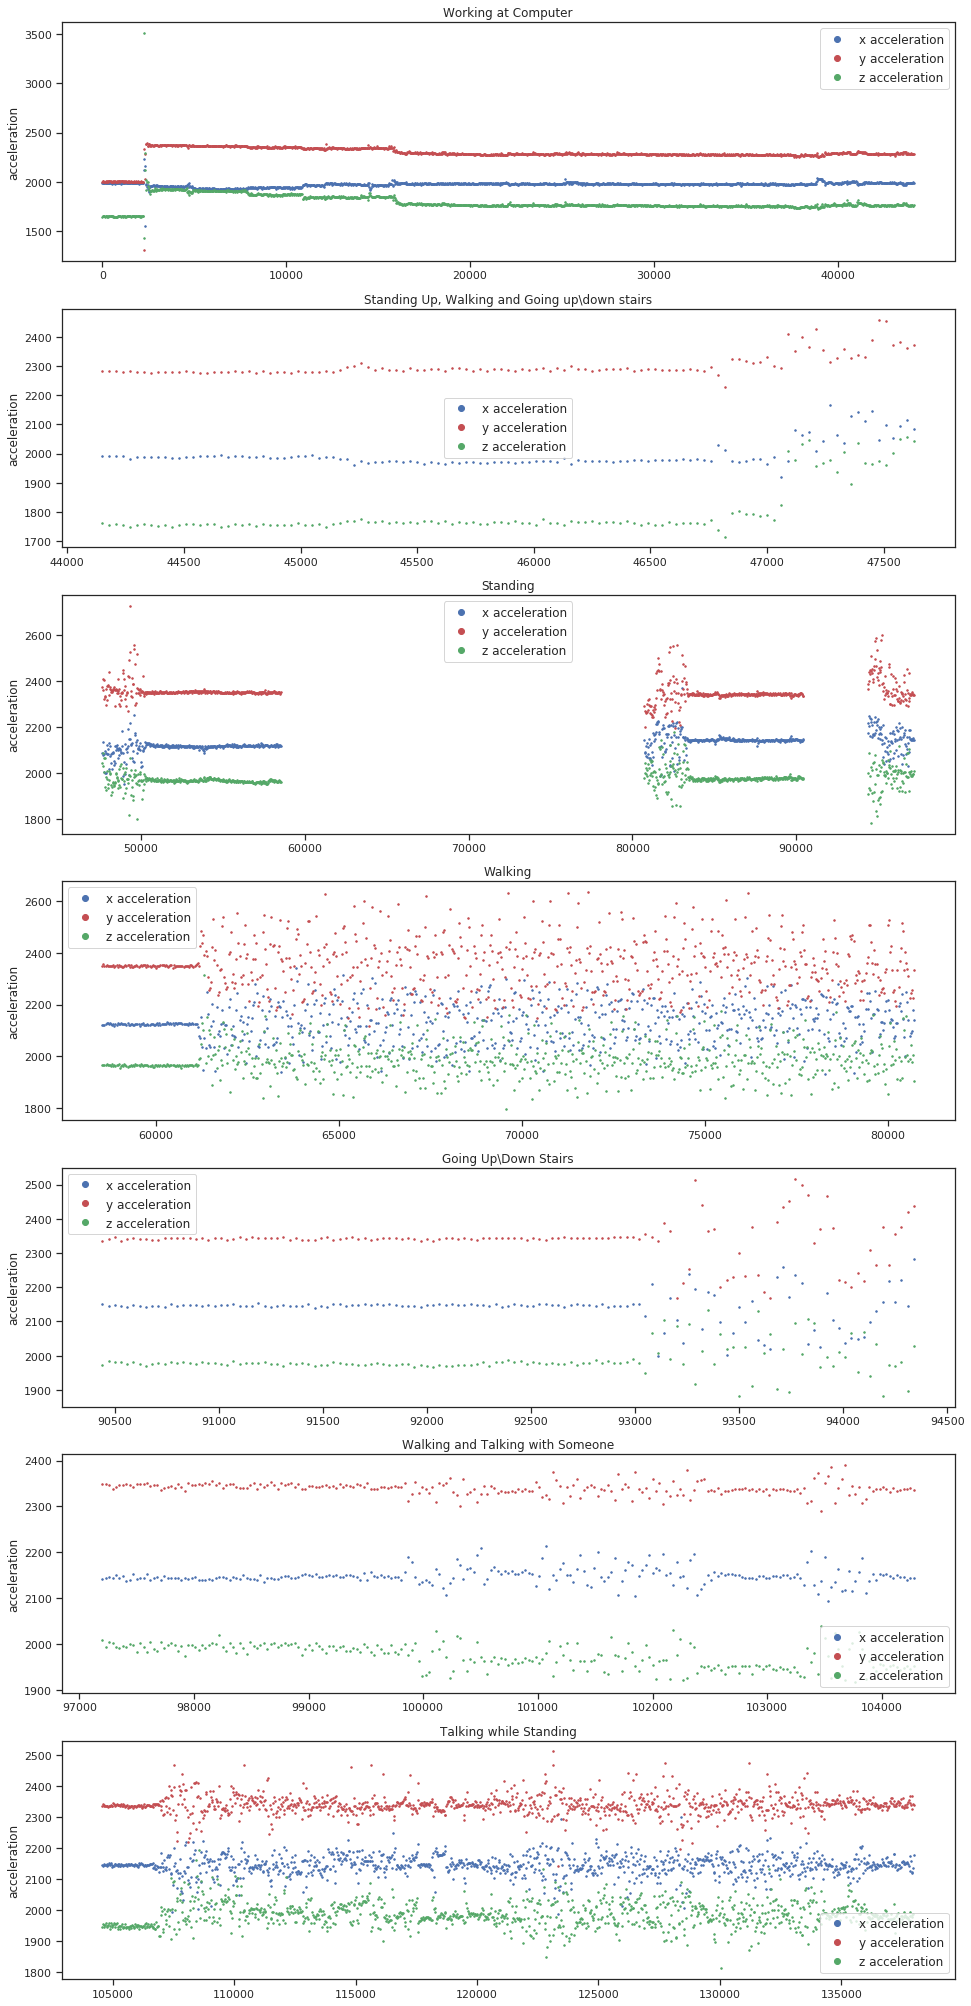

In [5]:
sns.set(style='ticks')

activities = ['Working at Computer', 'Standing Up, Walking and Going up\down stairs',
              'Standing', 'Walking', 'Going Up\Down Stairs',
              'Walking and Talking with Someone', 'Talking while Standing']


fig, axes =  plt.subplots(7, 1)
fig.set_size_inches(16,36)


for idx, activity in enumerate(activities): 
    ax = axes[idx]
    activity_records = df[df.label == (idx+1)][::30]

    ax.plot(activity_records.time, activity_records.x, 'bo', markersize=1.5)
    ax.plot(activity_records.time, activity_records.y, 'ro', markersize=1.5)
    ax.plot(activity_records.time, activity_records.z, 'go', markersize=1.5)

    ax.set_title(activity)
    ax.legend(['x acceleration', 'y acceleration', 'z acceleration'], fontsize=12, markerscale=4)
    ax.set_ylabel('acceleration')

plt.show()

#### Some labels seem to be incorrect. For example, consider time interval from 55000 to 65000 of this person.

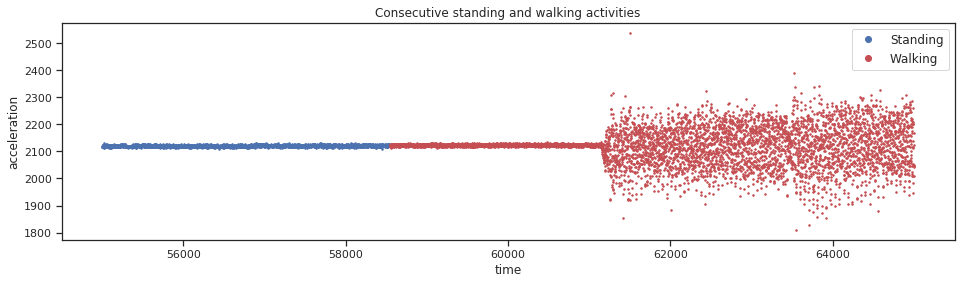

In [6]:
plt.figure(figsize=(16,4))

df_part = df[(df.time>55000) & (df.time < 65000)]

df_standing = df_part[df_part.label==3]
df_walking = df_part[df_part.label==4]

ax = plt.gca()

ax.plot(df_standing.time, df_standing.x, 'bo', markersize=1.5)
ax.plot(df_walking.time, df_walking.x, 'ro', markersize=1.5)

ax.set_ylabel('acceleration')
ax.set_xlabel('time')
ax.set_title('Сonsecutive standing and walking activities')
ax.legend(['Standing', 'Walking'], fontsize=12, markerscale=4)

plt.show()

#### We can see that person was standing till time ~61000, but  records from time ~58500 are labeled as walking activity.

### Take a look at how walking activity acceleration records differ for every person

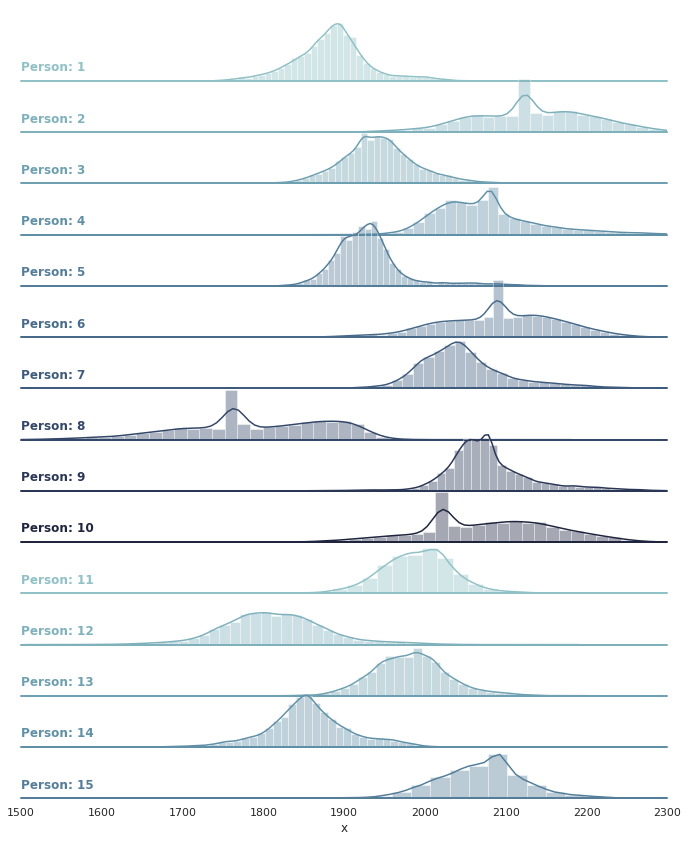

In [7]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

walking_records = dfs[dfs.label == 4]

g = sns.FacetGrid(walking_records, row="person", hue="person", aspect=15, height=.5, palette=pal)
g.fig.set_size_inches(10,12)
g.set(xlim=(1500, 2300))

# # Draw the densities in a few steps
g.map(sns.distplot, "x")
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, f'Person: {label}', fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True);

####  Every person shows very different acceleration's distribution 

#### Split each dataset on train, test and validation parts
Use activity labels so that every activity will be preserved in train/test/validation datasets

In [8]:
def train_test_split(dataframe, train_size=0.6, test_size=0.2):
        train_df = pd.DataFrame(columns=dataframe.columns)
        test_df = pd.DataFrame(columns=dataframe.columns)
        validation_df = pd.DataFrame(columns=dataframe.columns)

        for activity in dataframe.label.unique():
            activity_records = dataframe[dataframe.label == activity]
            train_test_delimiter = round(len(activity_records) * train_size)
            test_validation_delimiter = round(len(activity_records) * (train_size+test_size))
            
            train_df = train_df.append(activity_records.iloc[:train_test_delimiter])
            test_df = test_df.append(activity_records.iloc[train_test_delimiter:test_validation_delimiter])
            validation_df = test_df.append(activity_records.iloc[test_validation_delimiter:])

            
        train_df = train_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)
        validation_df = validation_df.reset_index(drop=True)
        
        return train_df, test_df, validation_df
        
train_dataframes = []
test_dataframes = []
validation_dataframes = []

for person in dfs.person.unique():
    dataframe = dfs[dfs.person == person]
    train_df, test_df, validation_df = train_test_split(dataframe)
    
    train_dataframes.append(train_df)
    test_dataframes.append(test_df)
    validation_dataframes.append(validation_df)

### Feature extraction
[This paper](https://pdfs.semanticscholar.org/8a4e/731d37c7d6084be2b3c1db56a860eeebafb1.pdf) is used for activity recognition by accelerometer data, but we can use the same features in this task. Feature extraction paragraph describes how to calculate features.

In [9]:
def get_sliding_windows(dataframe, window_size, overlap_size):    
    curr_index = 0
    rows_count = len(dataframe)
    
    while curr_index < rows_count - window_size:
        sliding_window = dataframe[['x','y','z']].iloc[curr_index:curr_index+window_size].reset_index(drop=True)
            
        yield sliding_window
        curr_index += overlap_size if overlap_size else window_size


Next features would be calculated:
1. Mean value (for every axis)
2. Standard Deviation  (for every axis)
3. Energy
4. Correlation  (for every pair of axes)

In [10]:
def calculate_statistics(rows):
    # Calculate pearson correlation between axes
    corr = rows.astype('float64').corr()
    
    # Calculate energy (sum of the squared discrete FFT component magnitudes of the signal)
    fft = np.fft.fftn(rows)
    energy = np.sum(np.abs(fft)**2)/fft.size
    
    features = [
        rows.x.mean(), 
        rows.y.mean(),
        rows.z.mean(),
        
        rows.x.std(),
        rows.y.std(),
        rows.z.std(),
        
        corr.x.y,
        corr.x.z,
        corr.y.z,
        
        energy,
    ]
    
    return features

In [11]:
def get_features(dataframe, window_size=256, overlap_size=128):
    result = []
    for window in get_sliding_windows(dataframe, window_size, overlap_size):
        result.append(calculate_statistics(window))
        
    return np.array(result)

In [12]:
# Calculate features for SVM model for every dataset and save
train_data = [get_features(df) for df in train_dataframes]
test_data = [get_features(df) for df in test_dataframes]
validation_data = [get_features(df) for df in validation_dataframes]

FEATURES_FOLDER = './features'

np.save(f'{FEATURES_FOLDER}/train_data_256', train_data)
np.save(f'{FEATURES_FOLDER}/test_data_256', test_data)
np.save(f'{FEATURES_FOLDER}/validation_data_256', validation_data)

In [13]:
# Calculate features for LSTM model for  every dataset and save
train_data = [get_features(df, 128, 64) for df in train_dataframes]
test_data = [get_features(df, 128, 64) for df in test_dataframes]
validation_data = [get_features(df, 128, 64) for df in validation_dataframes]


np.save(f'{FEATURES_FOLDER}/train_data_128', train_data)
np.save(f'{FEATURES_FOLDER}/test_data_128', test_data)
np.save(f'{FEATURES_FOLDER}/validation_data_128', validation_data)